In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import GRU

Download Tesla stock data from Yahoo Finance

In [ ]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2024,1,1 )
tesla_data = yf.download('TSLA', start=start, end=end)
tesla_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...,...
2023-12-22,252.539993,252.539993,258.220001,251.369995,256.760010,93249800
2023-12-26,256.609985,256.609985,257.970001,252.910004,254.490005,86892400


data exploration 

In [27]:
tesla_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500


In [28]:
tesla_data.shape

(1006, 6)

In [29]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, TSLA)  1006 non-null   float64
 1   (Close, TSLA)      1006 non-null   float64
 2   (High, TSLA)       1006 non-null   float64
 3   (Low, TSLA)        1006 non-null   float64
 4   (Open, TSLA)       1006 non-null   float64
 5   (Volume, TSLA)     1006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.0 KB


In [31]:
prices = tesla_data['Close'].values
prices = prices.reshape(-1, 1)


In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


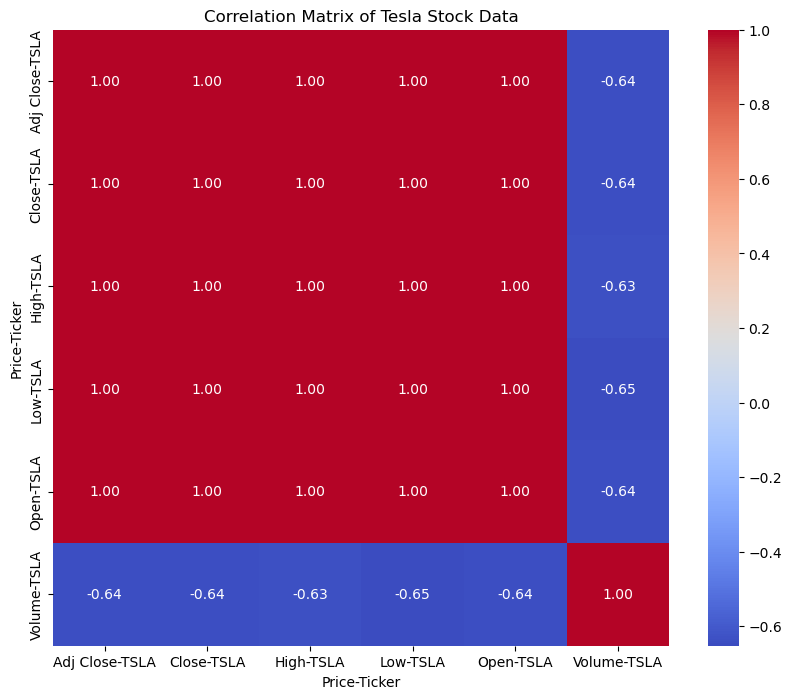

In [33]:
correlation_matrix = tesla_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Tesla Stock Data')
plt.show()

Plot the closing prices of Tesla stock over time

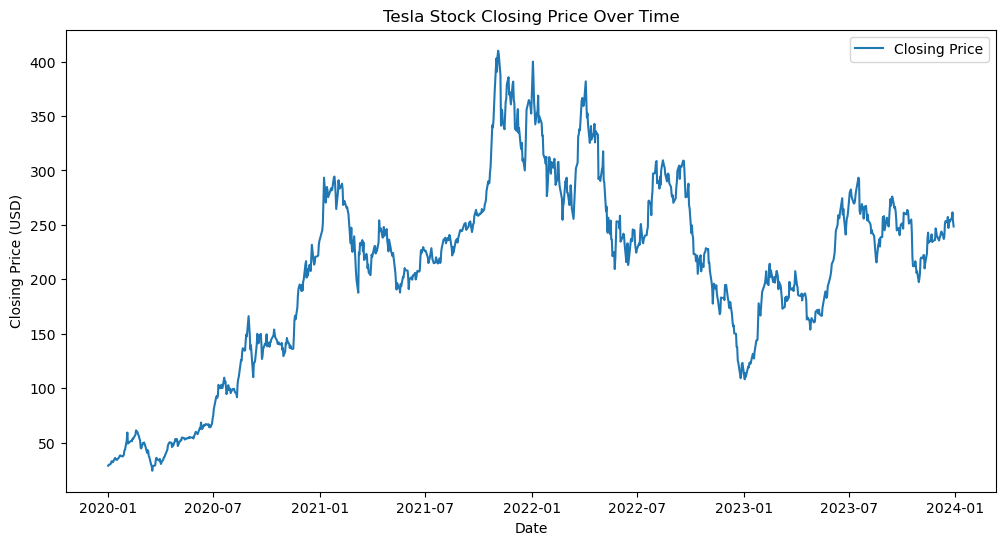

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_data['Close'], label='Closing Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


boxplot to show the distribution of stock prices and detect outliers

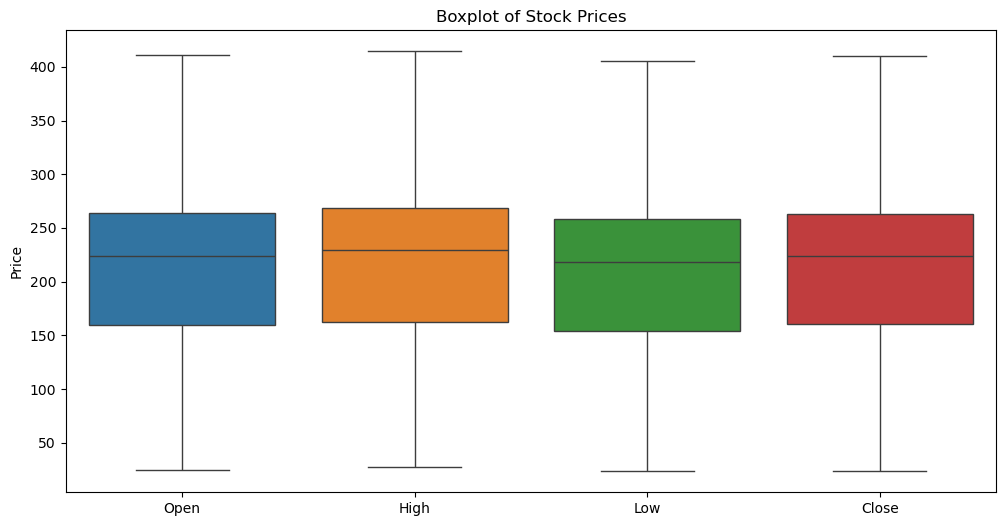

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=tesla_data[['Open', 'High', 'Low', 'Close']])
plt.title('Boxplot of Stock Prices')
plt.ylabel('Price')
plt.show()

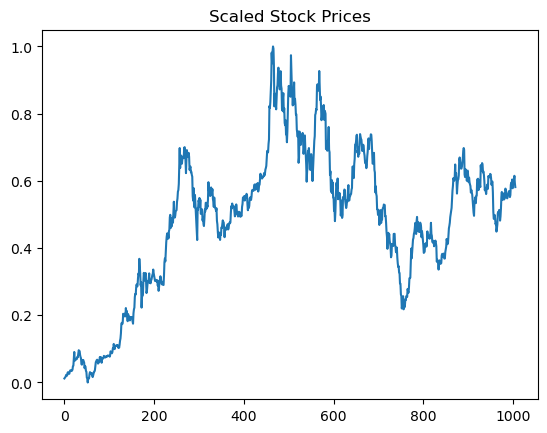

In [36]:
plt.plot(scaled_prices)
plt.title("Scaled Stock Prices")
plt.show()

In [37]:
tesla_data.isnull().sum()


Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64

In [38]:
print(scaled_prices.shape)  # This should give you something like (1510, 1)


(1006, 1)


In [40]:
def create_dataset(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Create sequences of 'time_steps'
        y.append(data[i+time_steps])    # The target is the next price after the sequence
    return np.array(X), np.array(y)

 number of days for predicting future prices

In [41]:
time_steps = 50
X, y = create_dataset(scaled_prices, time_steps)

train_size = int(len(X) * 0.8)  
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (764, 50, 1), y_train shape: (764, 1)
X_test shape: (192, 50, 1), y_test shape: (192, 1)


In [42]:

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),  
    LSTM(50, return_sequences=False),  
    Dense(25, activation='relu'),      
    Dense(1)                          
])

model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()


c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1146 - val_loss: 0.0042
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

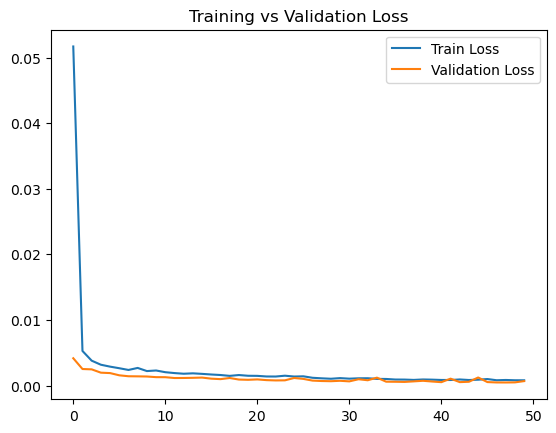

In [43]:

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


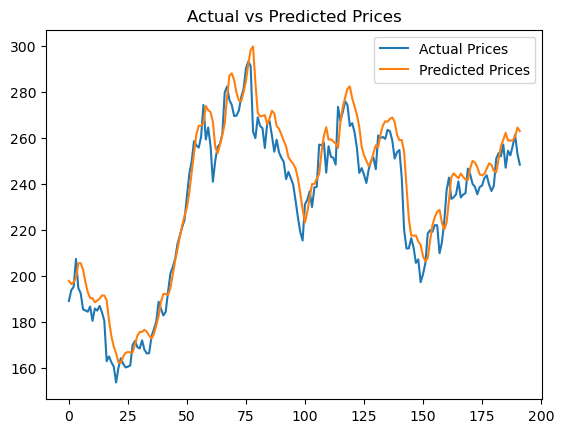

In [44]:

predictions = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()


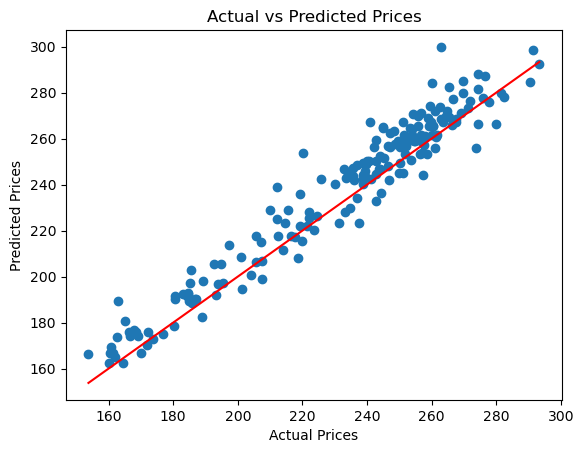

In [45]:
plt.scatter(actual_prices, predicted_prices)
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

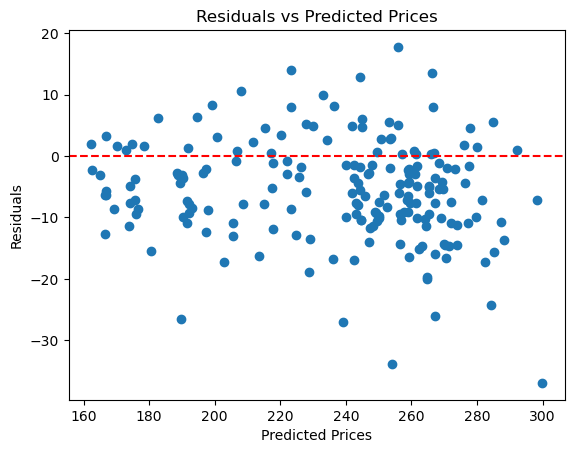

In [46]:
residuals = actual_prices - predicted_prices
plt.scatter(predicted_prices, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()


In [47]:
print(f"Actual prices shape: {actual_prices.shape}")
print(f"Predicted prices shape: {predicted_prices.shape}")


Actual prices shape: (192, 1)
Predicted prices shape: (192, 1)


In [48]:
mae = mean_absolute_error(actual_prices.flatten(), predicted_prices.flatten())


In [ ]:
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


 Plot the actual prices vs predicted prices

In [51]:

model.save('stock_price_prediction_model.keras')
print("stock_price_prediction_model.keras")


stock_price_prediction_model.keras
